In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', None)


In [3]:
# 1) Load
df = pd.read_csv("creditcard.csv")
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64

Class
0    0.998273
1    0.001727
Name: count, dtype: float64

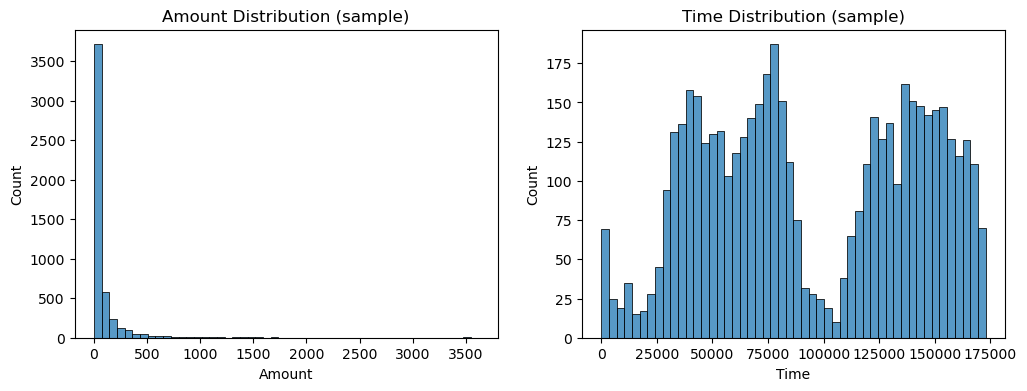

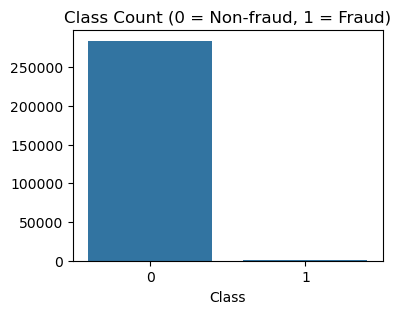

In [5]:
# 2.1 Missing values
df.isna().sum()

# 2.2 Class balance
class_counts = df['Class'].value_counts()
class_ratio = class_counts / class_counts.sum()
display(class_counts, class_ratio)

# 2.3 Amount & Time quick stats
df[['Time', 'Amount']].describe()

# 2.4 Visuals (downsample for speed)
sample = df.sample(n=min(5000, len(df)), random_state=RANDOM_STATE)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(sample['Amount'], bins=50, ax=ax[0], kde=False)
ax[0].set_title('Amount Distribution (sample)')
sns.histplot(sample['Time'], bins=50, ax=ax[1], kde=False)
ax[1].set_title('Time Distribution (sample)')
plt.show()

# 2.5 Class distribution bar
plt.figure(figsize=(4,3))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Count (0 = Non-fraud, 1 = Fraud)')
plt.show()


In [7]:
# 3) Split
X = df.drop(columns=['Class'])
y = df['Class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((227845, 30), (56962, 30), 0.001729245759178389, 0.0017204452090867595)

In [9]:
# 4) Preprocess columns
num_cols_to_scale = ['Amount', 'Time']
all_other_cols = [c for c in X.columns if c not in num_cols_to_scale]

preprocess = ColumnTransformer(
    transformers=[
        ('scale_amt_time', StandardScaler(), num_cols_to_scale),
        ('pass_through', 'passthrough', all_other_cols)
    ],
    remainder='drop'
)

# To verify order after transformation
feature_order = num_cols_to_scale + all_other_cols
len(feature_order), feature_order[:5]


(30, ['Amount', 'Time', 'V1', 'V2', 'V3'])

In [11]:
# 5) Class weights to fight imbalance
classes = np.array([0,1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {0: weights[0], 1: weights[1]}
class_weight


{0: 0.5008661206149896, 1: 289.14340101522845}

In [13]:
# 5.1 Pipeline
logreg_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LogisticRegression(
        solver='liblinear', class_weight=class_weight, random_state=RANDOM_STATE
    ))
])

logreg_clf.fit(X_train, y_train)

# 5.2 Eval (ROC-AUC & PR-AUC)
proba_lr = logreg_clf.predict_proba(X_test)[:,1]
roc_lr = roc_auc_score(y_test, proba_lr)
pr_lr = average_precision_score(y_test, proba_lr)

print(f"LogReg ROC-AUC: {roc_lr:.4f}")
print(f"LogReg PR-AUC : {pr_lr:.4f}")


LogReg ROC-AUC: 0.9721
LogReg PR-AUC : 0.7189


In [15]:
rf_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1,
        class_weight='balanced', random_state=RANDOM_STATE
    ))
])

rf_clf.fit(X_train, y_train)
proba_rf = rf_clf.predict_proba(X_test)[:,1]
roc_rf = roc_auc_score(y_test, proba_rf)
pr_rf = average_precision_score(y_test, proba_rf)

print(f"RF ROC-AUC: {roc_rf:.4f}")
print(f"RF PR-AUC : {pr_rf:.4f}")


RF ROC-AUC: 0.9618
RF PR-AUC : 0.8651


In [29]:
smote = SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.1)  # create modest balance

smote_lr = ImbPipeline(steps=[
    ('prep', preprocess),
    ('smote', smote),
    ('model', LogisticRegression(solver='liblinear', random_state=RANDOM_STATE))
])

param_grid = {
    'model__C': [0.1, 1.0, 10.0],
    'model__class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_smote_lr = GridSearchCV(
    estimator=smote_lr,
    param_grid=param_grid,
    scoring='average_precision',  # PR-AUC focus
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_smote_lr.fit(X_train, y_train)
grid_smote_lr.best_params_, grid_smote_lr.best_score_


Fitting 5 folds for each of 6 candidates, totalling 30 fits


({'model__C': 10.0, 'model__class_weight': None}, 0.758879456493742)

In [19]:
# Evaluate best SMOTE-LR on test
proba_smote_lr = grid_smote_lr.predict_proba(X_test)[:,1]
roc_smote_lr = roc_auc_score(y_test, proba_smote_lr)
pr_smote_lr = average_precision_score(y_test, proba_smote_lr)
print(f"SMOTE-LR ROC-AUC: {roc_smote_lr:.4f}")
print(f"SMOTE-LR PR-AUC : {pr_smote_lr:.4f}")


SMOTE-LR ROC-AUC: 0.9660
SMOTE-LR PR-AUC : 0.7505


Best model by PR-AUC: RandomForest (cw) → 0.8650707011528774


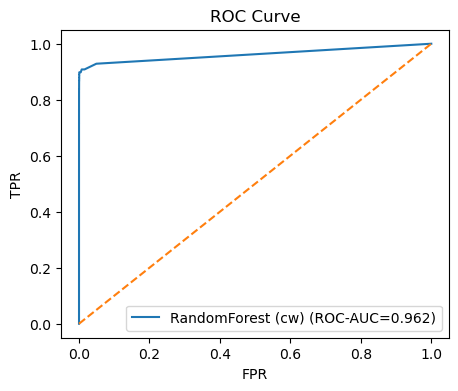

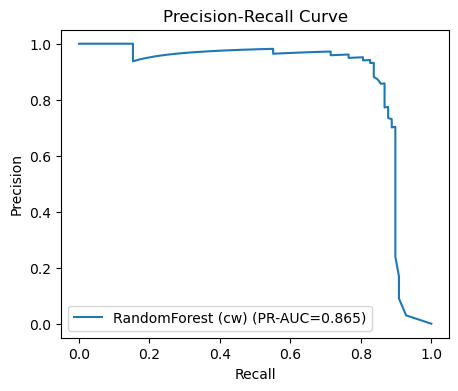

In [21]:
# Choose best by PR-AUC (often better for rare class)
models = {
    'LogReg (cw)': proba_lr,
    'RandomForest (cw)': proba_rf,
    'SMOTE+LogReg (cv)': proba_smote_lr
}
pr_aucs = {k: average_precision_score(y_test, v) for k, v in models.items()}
best_name = max(pr_aucs, key=pr_aucs.get)
best_proba = models[best_name]
print("Best model by PR-AUC:", best_name, "→", pr_aucs[best_name])

# ROC curve
fpr, tpr, _ = roc_curve(y_test, best_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'{best_name} (ROC-AUC={roc_auc_score(y_test, best_proba):.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y_test, best_proba)
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f'{best_name} (PR-AUC={average_precision_score(y_test, best_proba):.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend(); plt.show()


In [23]:
def find_best_threshold(y_true, y_score, optimize_for='f1'):
    prec, rec, th = precision_recall_curve(y_true, y_score)
    th = np.append(th, 1.0)  # align lengths
    if optimize_for == 'f1':
        f1 = 2 * (prec*rec) / (prec + rec + 1e-12)
        idx = np.nanargmax(f1)
        return th[idx], prec[idx], rec[idx], f1[idx]
    elif optimize_for == 'recall@precision':
        # Example: recall at >= 0.8 precision
        target_p = 0.80
        mask = prec >= target_p
        if mask.any():
            idx = np.argmax(rec[mask])  # highest recall where precision>=target
            true_idx = np.arange(len(prec))[mask][idx]
            f1 = 2 * (prec[true_idx]*rec[true_idx]) / (prec[true_idx]+rec[true_idx]+1e-12)
            return th[true_idx], prec[true_idx], rec[true_idx], f1
        else:
            return 0.5, prec[np.argmax(rec)], np.max(rec), None

best_th, bp, br, bf1 = find_best_threshold(y_test, best_proba, optimize_for='f1')
best_th, bp, br, bf1


(0.29, 0.9318181818181818, 0.8367346938775511, 0.8817204301070282)

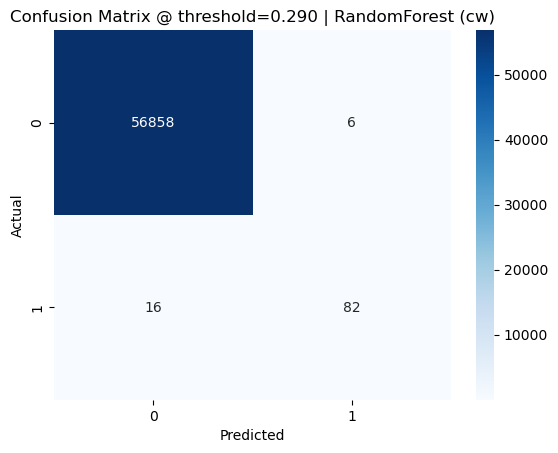

              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9318    0.8367    0.8817        98

    accuracy                         0.9996     56962
   macro avg     0.9658    0.9183    0.9408     56962
weighted avg     0.9996    0.9996    0.9996     56962



In [25]:
# Confusion matrix @ tuned threshold
y_pred_best = (best_proba >= best_th).astype(int)

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix @ threshold={best_th:.3f} | {best_name}')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

print(classification_report(y_test, y_pred_best, digits=4))


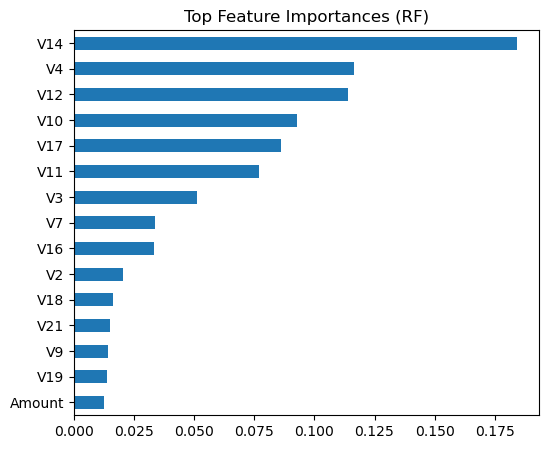

In [27]:
if 'RandomForest' in best_name:
    # Refit standalone RF to access feature importances easily
    rf = RandomForestClassifier(
        n_estimators=300, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1
    )
    X_train_trans = preprocess.fit_transform(X_train)
    X_test_trans  = preprocess.transform(X_test)
    rf.fit(X_train_trans, y_train)
    
    importances = rf.feature_importances_
    fi = pd.Series(importances, index=feature_order).sort_values(ascending=False).head(15)
    fi.plot(kind='barh', figsize=(6,5)); plt.gca().invert_yaxis()
    plt.title('Top Feature Importances (RF)')
    plt.show()

else:
    # Logistic Regression coefficients
    lr = LogisticRegression(solver='liblinear', class_weight=class_weight, random_state=RANDOM_STATE)
    X_train_trans = preprocess.fit_transform(X_train)
    X_test_trans  = preprocess.transform(X_test)
    lr.fit(X_train_trans, y_train)
    
    coefs = pd.Series(lr.coef_[0], index=feature_order).sort_values(key=np.abs, ascending=False).head(15)
    coefs.plot(kind='barh', figsize=(6,5)); plt.gca().invert_yaxis()
    plt.title('Top Coefficients (abs) — Logistic Regression')
    plt.show()


In [37]:
#prediction function
def predict_transaction(model, transaction_dict, threshold=0.29): #best_threshold from randomForest
    """
    Predict if a transaction is fraud or not using custom threshold.
    
    Args:
        model : trained pipeline / best_estimator_
        transaction_dict : dict of transaction details
                          Example:
                          {
                              "Time": 50000,
                              "Amount": 120.5,
                              "V1": -1.23,
                              ...
                              "V28": -0.67
                          }
        threshold : float (default=0.29)
    
    Returns:
        str : "Fraud" or "Not Fraud"
        float : fraud probability
    """
    # Convert dict -> DataFrame
    df_input = pd.DataFrame([transaction_dict])
    
    # Predict fraud probability
    proba = model.predict_proba(df_input)[:, 1][0]
    
    # Apply custom threshold
    prediction = "Fraud" if proba >= threshold else "Not Fraud"
    
    return prediction, proba


In [39]:
best_model = grid_smote_lr.best_estimator_

sample_txn = {
    "Time": 50000,
    "V1": -1.3598071336738,
    "V2": -0.0727811733098497,
    "V3": 2.53634673796914,
    "V4": 1.37815522427443,
    "V5": -0.338320769942518,
    "V6": 0.462387777762292,
    "V7": 0.239598554061257,
    "V8": 0.0986979012610507,
    "V9": 0.363786969611213,
    "V10": 0.0907941719789316,
    "V11": -0.551599533260813,
    "V12": -0.617800855762348,
    "V13": -0.991389847235408,
    "V14": -0.311169353699879,
    "V15": 1.46817697209427,
    "V16": -0.470400525259478,
    "V17": 0.207971241929242,
    "V18": 0.0257905801985591,
    "V19": 0.403992960255733,
    "V20": 0.251412098239705,
    "V21": -0.018306777944153,
    "V22": 0.277837575558899,
    "V23": -0.110473910188767,
    "V24": 0.0669280749146731,
    "V25": 0.128539358273528,
    "V26": -0.189114843888824,
    "V27": 0.133558376740387,
    "V28": -0.0210530534538215,
    "Amount": 149.62
}


pred, prob = predict_transaction(best_model, sample_txn, threshold=0.29)

print(f"Prediction: {pred}")
print(f"Fraud Probability: {prob:.4f}")

Prediction: Not Fraud
Fraud Probability: 0.0267
